In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

# Input data files are available in the read-only "../data/" directory

# Load the train data
train_values_file_path = '../data/train-set-values.csv'
train_values = pd.read_csv(train_values_file_path)
X = train_values.copy()

train_labels_file_path = '../data/train-set-labels.csv'
train_labels = pd.read_csv(train_labels_file_path)
y = train_labels.copy()

X_y = pd.concat([X.set_index('id'),y.set_index('id')], axis=1, join='inner').reset_index()

# Load the test data
test_file_path = '../data/test-set-values.csv'
test_values = pd.read_csv(test_file_path)
X_test = test_values.copy()

## pre-processing 

In the pre-pcessing step, we'll try to convert some of the useful features identified in EDA, into a form that can be fed to a ML model. We'll store that set of features in a data frame called `features_X` for 'train data' and `features_X_test` for 'test data'.

#### `funder`

As observed in EDA, `funder` has 1897 unique values (Some of which are due to spelling errors, capitalization errors, and data entry errors)

Lets first convert everything to lowecase to try and minimize capitalization errors if any

In [2]:
funder = X['funder'].astype(str)
funder = funder.str.lower()

funder_test = X_test['funder'].astype(str)
funder_test = funder_test.str.lower()

Then lets identify the values which are most likely to be the same and then replace similar values with one value. Function `replace_similar_categories` is written for this purpose. It uses the FuzzyWuzzy Package to calculate string similarity using Levenshtein distance ratio of similarity.

ref: https://www.datacamp.com/community/tutorials/fuzzy-string-python
 

In [3]:
from fuzzywuzzy import fuzz
from collections import defaultdict

def get_similar_categories(sr, threshold):
    replacements_dict = defaultdict(lambda: "other")
    unique_list = []

    for category in sr.unique():    
        is_unique = True
        replacements_dict[category] = category
        for unique_category in unique_list:        
            if (fuzz.ratio(category, unique_category) > threshold):
                replacements_dict[category] = unique_category
                is_unique = False
    #             print (category + " replaced by " + unique_category)
                break            
        if(is_unique):
            unique_list.append(category)    
    
    return replacements_dict

In [4]:
funder_similar_category_replacements = get_similar_categories(funder, 85)

In [5]:
funder = funder.map(funder_similar_category_replacements)
funder_test = funder_test.map(funder_similar_category_replacements)

Then lets replace the categories that occur less than 2% of the time with 'other'. Number 2% was empirically determined as a number that yields a reasonable number of categories.  

In [6]:
def get_less_occuring_categories(sr, threshold):
    val_counts = sr.value_counts(normalize=True)
    replacements_dict = defaultdict(lambda: "other")

    for category in sr.unique():
        if(val_counts.at[category] < threshold):
            replacements_dict[category] = 'other'
        else:
            replacements_dict[category] = category
    return replacements_dict        

In [7]:
funder_less_occuring_category_replacements = get_less_occuring_categories(funder, 0.02)

In [8]:
funder = funder.map(funder_less_occuring_category_replacements)
funder_test = funder_test.map(funder_less_occuring_category_replacements)

In [9]:
len(funder.unique())

9

In [10]:
features_X = funder.to_frame()
features_X_test = funder_test.to_frame()

#### `installer`

Since `installer` is very similar to `funder` in nature, we'll use the same preprocessing steps to `installer` as well.

In [11]:
installer = X['installer'].astype(str)
installer = installer.str.lower()

installer_test = X_test['installer'].astype(str)
installer_test = installer_test.str.lower()

installer_similar_category_replacements = get_similar_categories(installer, 85)

installer = installer.map(installer_similar_category_replacements)
installer_test = installer_test.map(installer_similar_category_replacements)

installer_less_occuring_category_replacements = get_less_occuring_categories(installer, 0.02)

installer = installer.map(installer_less_occuring_category_replacements)
installer_test = installer_test.map(installer_less_occuring_category_replacements)

In [12]:
len(installer.unique())

7

In [13]:
features_X = features_X.merge(installer, left_index=True, right_index=True)
features_X_test = features_X_test.merge(installer_test, left_index=True, right_index=True)
features_X

,funder,installer
0,other,other
1,other,other
2,other,other
3,other,other
4,other,other
...,...,...
59395,other,other
59396,other,other
59397,nan,nan
59398,other,other


#### `basin`

We can directly use `basin` as it contains only 9 categories.

In [14]:
features_X = features_X.merge(X['basin'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['basin'], left_index=True, right_index=True)
features_X

,funder,installer,basin
0,other,other,Lake Nyasa
1,other,other,Lake Victoria
2,other,other,Pangani
3,other,other,Ruvuma / Southern Coast
4,other,other,Lake Victoria
...,...,...,...
59395,other,other,Pangani
59396,other,other,Rufiji
59397,nan,nan,Rufiji
59398,other,other,Rufiji


#### Features related to the Geographical location

We'll consider `gps_height`, `longitude`, `latitude`, and, `region` to represent Geographical data.

In [15]:
features_X = features_X.merge(X['gps_height'], left_index=True, right_index=True)
features_X = features_X.merge(X['longitude'], left_index=True, right_index=True)
features_X = features_X.merge(X['latitude'], left_index=True, right_index=True)
features_X = features_X.merge(X['region'], left_index=True, right_index=True)

features_X_test = features_X_test.merge(X_test['gps_height'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['longitude'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['latitude'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['region'], left_index=True, right_index=True)

features_X

,funder,installer,basin,gps_height,longitude,latitude,region
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara
2,other,other,Pangani,686,37.460664,-3.821329,Manyara
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera
...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma


#### Feature related to Operation and Management

Out of the similar features identified in EDA, lets choose `management` as the feature to represent operation and management information.

In [16]:
features_X = features_X.merge(X['management'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['management'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other
...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc


#### Feature related to Extraction Type

Out of the similar features identified in EDA, lets choose `extraction_type_class` as the feature to represent operation and management information.

In [17]:
features_X = features_X.merge(X['extraction_type_class'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['extraction_type_class'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity
...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump


#### Feature related to Cost

Out of the similar features identified in EDA, lets choose `payment` as the feature to represent cost type.

In [18]:
features_X = features_X.merge(X['payment'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['payment'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay
...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay


#### Feature related to Quality

Out of the similar features identified in EDA, lets choose `quality_group` as the feature to represent water quality.

In [19]:
features_X = features_X.merge(X['quality_group'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['quality_group'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good
...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good


#### Features related to Quantity

Out of the similar features identified in EDA, lets choose `quantity_group` as the feature to represent water quantity.

In [20]:
features_X = features_X.merge(X['quantity_group'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['quantity_group'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal
...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient


#### Features related to Source

Out of the similar features identified in EDA, lets choose `source_type` and `source_class` as the features to represent source.

In [21]:
features_X = features_X.merge(X['source_type'], left_index=True, right_index=True)
features_X = features_X.merge(X['source_class'], left_index=True, right_index=True)

features_X_test = features_X_test.merge(X_test['source_type'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['source_class'], left_index=True, right_index=True)

features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater


#### Feature related to Waterpoint Type

Out of the similar features identified in EDA, lets choose `waterpoint_type` as the feature to represent waterpoint type.

In [22]:
features_X = features_X.merge(X['waterpoint_type'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['waterpoint_type'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater,communal standpipe
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface,communal standpipe multiple
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater,communal standpipe multiple
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater,communal standpipe
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface,communal standpipe
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater,hand pump
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater,hand pump


#### Feature related to TSH

we'll consider the `amount_tsh` feature as well

In [23]:
features_X = features_X.merge(X['amount_tsh'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['amount_tsh'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type,amount_tsh
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater,communal standpipe,6000.0
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.0
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface,communal standpipe multiple,25.0
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater,communal standpipe multiple,0.0
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater,communal standpipe,10.0
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface,communal standpipe,4700.0
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater,hand pump,0.0
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater,hand pump,0.0


## feature engineering

#### Feature to represent pump age

We'll add a new feature to represent pump age using the data given in `construction_year`.

In [24]:
pump_age = 2013 - X['construction_year']
pump_age.replace(2013, np.nan, inplace=True)
pump_age.name = "pump_age"

pump_age_test = 2013 - X['construction_year']
pump_age_test.replace(2013, np.nan, inplace=True)
pump_age_test.name = "pump_age"


In [25]:
features_X = features_X.merge(pump_age, left_index=True, right_index=True)
features_X_test = features_X_test.merge(pump_age_test, left_index=True, right_index=True)

features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type,amount_tsh,pump_age
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater,communal standpipe,6000.0,14.0
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.0,3.0
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface,communal standpipe multiple,25.0,4.0
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater,communal standpipe multiple,0.0,27.0
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater,communal standpipe,10.0,14.0
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface,communal standpipe,4700.0,17.0
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater,hand pump,0.0,NaN
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater,hand pump,0.0,NaN


## Feature Encoding

### Transformers for features

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

mean_imputer = SimpleImputer(strategy='mean')
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
constant_imputer = SimpleImputer(strategy='constant')

oh_encoder = OneHotEncoder(handle_unknown='ignore')

#### Trasformer for Categorical data

In [27]:
categorical_cols = [col for col in features_X.columns if features_X[col].dtype == "object"]
print(categorical_cols)

categorical_transformer = Pipeline(steps=[
    ('imputer', constant_imputer),
    ('onehot', oh_encoder)
])

['funder', 'installer', 'basin', 'region', 'management', 'extraction_type_class', 'payment', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type']


#### Trasformer for Numerical data

In [28]:
numerical_cols = [col for col in features_X.columns if features_X[col].dtype in ['int64', 'float64']]
print(numerical_cols)

numerical_transformer = mean_imputer

['gps_height', 'longitude', 'latitude', 'amount_tsh', 'pump_age']


### Proprocessor

In [29]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

In [30]:
preprocessor.fit_transform(features_X)

<59400x105 sparse matrix of type '<class 'numpy.float64'>'
	with 945735 stored elements in Compressed Sparse Row format>

## Feature Selection

## modelling

### Model

In [31]:
from sklearn.ensemble import RandomForestClassifier

def make_rf_model(n_estimators=50, max_depth=5):
    return RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

### Pipeline

In [32]:
def make_my_pipeline(preprocessor, model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

### Measure 5-fold cross validation accuaracy

In [33]:
from sklearn.model_selection import cross_validate

def get_cross_val_accuracy(pipeline, k):
    scores = cross_validate(pipeline, features_X, y['status_group'], cv=k, scoring='accuracy', return_train_score=True)
    test_scores = scores['test_score']
    train_scores = scores['train_score']
    return {
        'test': test_scores.mean(), 
        'train': train_scores.mean()  
    }

### Tuning n_estimators and max_depth

In [34]:
k = 5  ## k in k-fold cross validation
results = {}
    
for n_estimators in range(100, 201, 100):
    n_estimators_results = {} 
    for max_depth in range(6, 7, 2):
#         model = make_rf_model(n_estimators = n_estimators, max_depth = max_depth)
        model = make_rf_model(n_estimators = n_estimators)
        pipeline = make_my_pipeline(preprocessor, model)
        test_train_cross_val_accuracy = get_cross_val_accuracy(pipeline, k)
        n_estimators_results[max_depth] = test_train_cross_val_accuracy
    results[n_estimators] = n_estimators_results

results

{100: {6: {'test': 0.7212457912457912, 'train': 0.7221801346801346}},
 200: {6: {'test': 0.7206902356902357, 'train': 0.7214898989898989}}}

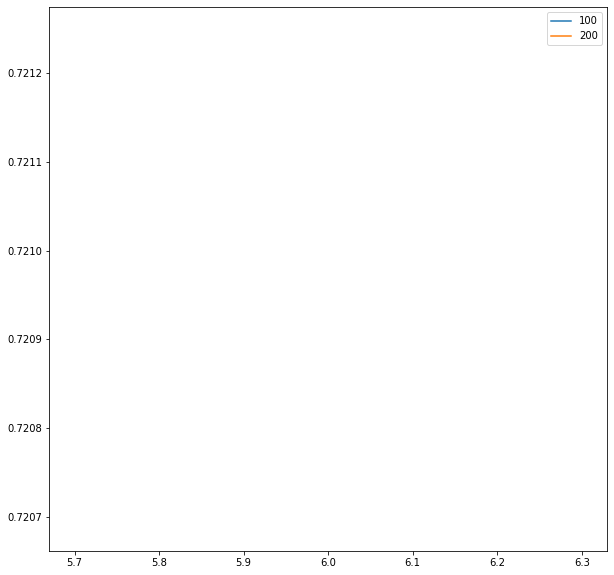

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))

for key in results.keys():
    plt.plot(list(results[key].keys()), [res_dict['test'] for res_dict in list(results[key].values())])

plt.legend(list(results.keys()))
    
plt.show()

In [36]:
best_n_estimator = 200
best_max_depth = 6

final_model = make_rf_model(best_n_estimator, best_max_depth)
final_pipeline = make_my_pipeline(preprocessor, final_model)

In [37]:
final_pipeline.fit(features_X, y['status_group'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region',
                                                   'management',
                                                   'extraction_type_class',
                                                   'payment', 'quality_group',
                                                   'quantity_group',
                                                   'source_type',
                                          

### Generate Test Predictions

In [38]:
preds_test = final_pipeline.predict(features_X_test)
preds_series = pd.Series(preds_test, name="status_group")

submission = X_test['id'].to_frame(name='id').merge(preds_series, left_index=True, right_index=True)

submission.to_csv('../submissions/attempt1.csv', index=False)

## post-processing